# Estimating surface area around lower and upper vertical meridians in V1


Here we demonstrate the utility of our toolbox as well as the validity of our predictions by determining V1 cortical surface area dedicated to representing different portions of the visual field. 
Here we will:
1. Use the Wang et al. probabilistic atlas and resample visual area masks to the native cortical surface of the subject;
2. Estimate the cortical surface area dedicated to different visual field portions;
3. Determine group differences in VMA and HVA;
4. Visualize wedge-ROIS

## Import libraries and functions

In [24]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os
import numpy as np
import nibabel as nib

sys.path.append('..')

from ipywidgets import interact, Dropdown
from nilearn import plotting

## 1. Generate ROIs for dorsal and ventral V1-2 using Wang et al. probabilistic atlas

To estimate the cortical surface area of V1 representing different portions of the visual field, we established an automated (and fast) framework inspired by an [earlier work](https://www.nature.com/articles/s41467-023-37280-8). First, we need to resample the ventral and dorsal portions of V1 and V2 from the fs_LR_32k surface space to the individual's native space. Then, we combine the V1 and V2 masks, along with their foveal confluence, to ensure that V1 is fully contained within our region of interest. Note that we demonstrate the process step by step for the HCP dataset, but we have a single script that encapsulates all these steps, which was applied to the ABCD dataset.

In [3]:
# Number of cortical nodes
number_cortical_nodes = int(64984)
number_hemi_nodes = int(number_cortical_nodes / 2)

# Wang atlas
portions = {'ventral': ['V1v', 'V2v'],
            'dorsal': ['V1d', 'V2d']}

for portion in ['ventral', 'dorsal']:
    list_of_ventral_portions = np.zeros([len(portions[portion]), 64984])
    for i in range(len(portions[portion])):
        region_of_interest = np.reshape(scipy.io.loadmat('/home/ribeiro/Projects/deepRetinotopy_validation/functions/'
                                                        'rois/VisualAreasLabels_Wang2015/' + portions[portion][i] + '_labels.mat')[
                                                            portions[portion][i]][ 0:64984], (-1))
        mask_nan = np.isnan(region_of_interest)
        region_of_interest[mask_nan] = 0
        list_of_ventral_portions[i, :] = region_of_interest
        # print(np.unique(region_of_interest))

    final_mask_L = np.sum(list_of_ventral_portions, axis=0)[
        0:number_hemi_nodes]
    final_mask_R = np.sum(list_of_ventral_portions, axis=0)[
        number_hemi_nodes:number_cortical_nodes]

    template_rh = nib.load('/BULK/LABDATA/openneuro_deepRetinotopy/ds004440/derivatives/freesurfer/sub-ACM07/deepRetinotopy/sub-ACM07.fs_predicted_eccentricity_rh_curvatureFeat_model.func.gii')
    template_lh = nib.load('/BULK/LABDATA/openneuro_deepRetinotopy/ds004440/derivatives/freesurfer/sub-ACM07/deepRetinotopy/sub-ACM07.fs_predicted_eccentricity_lh_curvatureFeat_model.func.gii')

    template_rh.agg_data()[final_mask_R == 0] = 0
    template_rh.agg_data()[final_mask_R != 0] = 1

    template_lh.agg_data()[final_mask_L == 0] = 0
    template_lh.agg_data()[final_mask_L != 0] = 1

    template_rh.agg_data()[:] = np.array(template_rh.agg_data()[:], dtype='int')
    template_lh.agg_data()[:] = np.array(template_lh.agg_data()[:], dtype='int')

    template_lh = nib.gifti.GiftiDataArray(template_lh.agg_data()[:], intent='NIFTI_INTENT_LABEL')
    template_lh = nib.gifti.GiftiImage(darrays=[template_lh])

    template_rh = nib.gifti.GiftiDataArray(template_rh.agg_data()[:], intent='NIFTI_INTENT_LABEL')
    template_rh = nib.gifti.GiftiImage(darrays=[template_rh])

    nib.save(template_rh, './V12'+portion+'.rh.32k_fs_LR.label.gii')
    nib.save(template_lh, './V12'+portion+'.lh.32k_fs_LR.label.gii')

In [20]:
%%bash
ml connectomeworkbench/1.5.0

dirHCP=/home/ribeiro/Projects/deepRetinotopy_validation/templates/
dirFS=/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/

cd $dirFS
for dirSub in *; do
    for hemisphere in lh rh; do
        for portion in ventral dorsal; do
            if [ "$hemisphere" == 'lh' ]; then
                hemi='L'
            else
                hemi='R'
            fi
            wb_command -label-resample /home/ribeiro/Projects/deepRetinotopy_validation/notebooks/V12"$portion"."$hemisphere".32k_fs_LR.label.gii \
                    $dirHCP/fs_LR-deformed_to-fsaverage."$hemi".sphere.32k_fs_LR.surf.gii \
                    $dirSub/surf/"$hemisphere".sphere.reg.surf.gii ADAP_BARY_AREA $dirSub/deepRetinotopy/"$dirSub".V12"$portion"-roi."$hemisphere".native.label.gii \
                    -area-surfs $dirSub/surf/"$dirSub"."$hemisphere".midthickness.32k_fs_LR.surf.gii $dirSub/surf/"$hemisphere".midthickness.surf.gii
        done
    done
done

/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer


We will also generate V1-3 ROIs that include the foveal confluence (drawn manually). These ROIs can be similarly resampled to each subject's native space.

In [21]:
def add_fovea(list, hemisphere='lh'):
    from functions.visualization import ROIs_WangParcels as roi
    """Adding fovea to the left hemisphere V1, V2 and V3 parcels
    (Wang et at., 2015).

    Args:
      list: [v1_dorsal, v1_ventral, v1_fovea, v2_dorsal, v2_ventral,
      v2_fovea, v3_dorsal, v3_ventral, v3_fovea]
      hemisphere: 'lh' or 'rh'

    Returns:
      V1_L (numpy array): V1_L mask (number of vertices,)

      V2_L (numpy array): V2_L mask (number of vertices,)

      V3_L (numpy array): V3_L mask (number of vertices,)
    """

    visual_cortex_L = np.zeros((32492, len(list)))
    visual_cortex_R = np.zeros((32492, len(list)))
    for i in range(len(list)):
        area = [list[i]]
        final_mask_L, final_mask_R, index_L_mask, index_R_mask = roi(area)
        visual_cortex_L[:, i][final_mask_L == 1] = i + 1
        visual_cortex_R[:, i][final_mask_R == 1] = i + 1

    for i in range(3):
        visual_cortex_L[:, i * 3 + 1][
            visual_cortex_L[:, i * 3 + 1] != 0] = i + 1
        visual_cortex_L[:, i * 3 + 2][
            visual_cortex_L[:, i * 3 + 2] != 0] = i + 1
        visual_cortex_R[:, i * 3 + 1][
            visual_cortex_R[:, i * 3 + 1] != 0] = i + 1
        visual_cortex_R[:, i * 3 + 2][
            visual_cortex_R[:, i * 3 + 2] != 0] = i + 1

    V1_L = np.sum(visual_cortex_L[:, 0:3], axis=1)
    V1_L[V1_L > 1] = 1
    V2_L = np.sum(visual_cortex_L[:, 3:6], axis=1)
    V2_L[V2_L > 1] = 2
    V3_L = np.sum(visual_cortex_L[:, 6:9], axis=1)
    V3_L[V3_L > 1] = 3

    V1_R = np.sum(visual_cortex_R[:, 0:3], axis=1)
    V1_R[V1_R > 1] = 1
    V2_R = np.sum(visual_cortex_R[:, 3:6], axis=1)
    V2_R[V2_R > 1] = 2
    V3_R = np.sum(visual_cortex_R[:, 6:9], axis=1)
    V3_R[V3_R > 1] = 3
    if hemisphere == 'lh':
        return V1_L, V2_L, V3_L
    else:
        return V1_R, V2_R, V3_R

# Adding fovea to Wang et al. (2015) visual areas
primary_visual_areas = ['V1d', 'V1v', 'fovea_V1', 'V2d', 'V2v',
                        'fovea_V2', 'V3d', 'V3v', 'fovea_V3']

visual_cortex_L = np.zeros((32492, 3))
visual_cortex_R = np.zeros((32492, 3))

V1_L, V2_L, V3_L = add_fovea(primary_visual_areas, hemisphere='lh')
V1_R, V2_R, V3_R = add_fovea(primary_visual_areas, hemisphere='rh')


visual_areas_L = np.concatenate((np.reshape(V1_L, (-1, 1)),
                                 np.reshape(V2_L, (-1, 1)),
                                 np.reshape(V3_L, (-1, 1)),
                                 visual_cortex_L), axis=1)
visual_areas_L = np.sum(visual_areas_L, axis=1)
visual_areas_L[V3_L == 3] = 3
visual_areas_L[V2_L == 2] = 2
visual_areas_L[V1_L == 1] = 1

visual_areas_R = np.concatenate((np.reshape(V1_R, (-1, 1)),
                                 np.reshape(V2_R, (-1, 1)),
                                 np.reshape(V3_R, (-1, 1)),
                                 visual_cortex_R), axis=1)
visual_areas_R = np.sum(visual_areas_R, axis=1)
visual_areas_R[V3_R == 3] = 3
visual_areas_R[V2_R == 2] = 2
visual_areas_R[V1_R == 1] = 1

# Saving V1-3 ROIs with foveal confluence
template_rh = nib.load('/BULK/LABDATA/openneuro_deepRetinotopy/ds004440/derivatives/freesurfer/sub-ACM07/deepRetinotopy/sub-ACM07.fs_predicted_eccentricity_rh_curvatureFeat_model.func.gii')
template_lh = nib.load('/BULK/LABDATA/openneuro_deepRetinotopy/ds004440/derivatives/freesurfer/sub-ACM07/deepRetinotopy/sub-ACM07.fs_predicted_eccentricity_lh_curvatureFeat_model.func.gii')

template_lh.agg_data()[:] = visual_areas_L
template_rh.agg_data()[:] = visual_areas_R

template_rh.agg_data()[:] = np.array(template_rh.agg_data()[:], dtype='int')
template_lh.agg_data()[:] = np.array(template_lh.agg_data()[:], dtype='int')

template_lh = nib.gifti.GiftiDataArray(template_lh.agg_data()[:], intent='NIFTI_INTENT_LABEL')
template_lh = nib.gifti.GiftiImage(darrays=[template_lh])

template_rh = nib.gifti.GiftiDataArray(template_rh.agg_data()[:], intent='NIFTI_INTENT_LABEL')
template_rh = nib.gifti.GiftiImage(darrays=[template_rh])

nib.save(template_rh, 'V123plusfovea.rh.32k_fs_LR.label.gii')
nib.save(template_lh, 'V123plusfovea.lh.32k_fs_LR.label.gii')

## 2. Estimate cortical surface area dedicated to representing different visual field portions

We start by defining functions for selecting vertices within V1 and at a pre-defined eccentricity range. Then, the polar angle maps are used to mask vertices representing different portions of the visual field. 

In [22]:
def compute_surface_area(vertices, faces, mask):
    """Compute surface area for masked region"""
    # Get triangles that have at least one vertex in the mask
    # (you might want all vertices in mask - see variation below)
    triangles = vertices[faces]
    
    # Calculate triangle areas using cross product
    v1 = triangles[:, 1] - triangles[:, 0]
    v2 = triangles[:, 2] - triangles[:, 0]
    areas = 0.5 * np.linalg.norm(np.cross(v1, v2), axis=1)
    
    # Only include triangles where all vertices are in the mask
    valid_faces = np.all(mask[faces], axis=1)
    return np.sum(areas[valid_faces])

def generate_masks(freesurfer_directory, subject_id, hemisphere, retinotopic_mapping, wedge_size=35):
    """Generate masks for wedges of specified size"""

    # Load your retinotopic maps
    if retinotopic_mapping == 'deepRetinotopy':
        polar_angle = nib.load(f'{freesurfer_directory}/{subject_id}/deepRetinotopy/{subject_id}.predicted_polarAngle_model.{hemisphere}.native.func.gii').darrays[0].data
        eccentricity = nib.load(f'{freesurfer_directory}/{subject_id}/deepRetinotopy/{subject_id}.predicted_eccentricity_model.{hemisphere}.native.func.gii').darrays[0].data
    elif retinotopic_mapping == 'empirical':
        polar_angle = nib.load(f'{freesurfer_directory}/{subject_id}/deepRetinotopy/{subject_id}.empirical_polarAngle.{hemisphere}.native.func.gii').darrays[0].data
        eccentricity = nib.load(f'{freesurfer_directory}/{subject_id}/deepRetinotopy/{subject_id}.empirical_eccentricity.{hemisphere}.native.func.gii').darrays[0].data
    
    # Dorsal ROI
    dorsal_roi = nib.load(f'{freesurfer_directory}/{subject_id}/deepRetinotopy/{subject_id}.V12dorsal-roi.{hemisphere}.native.label.gii').darrays[0].data==1
    # Ventral ROI
    ventral_roi = nib.load(f'{freesurfer_directory}/{subject_id}/deepRetinotopy/{subject_id}.V12ventral-roi.{hemisphere}.native.label.gii').darrays[0].data==1

    v123_roi = nib.load(f'{freesurfer_directory}/{subject_id}/deepRetinotopy/{subject_id}.V123plusfovea-roi.{hemisphere}.native.label.gii').darrays[0].data
    v1_roi = v123_roi == 1
    v2_roi = v123_roi == 2
    v1_plus = v1_roi | v2_roi

    # Define masks
    upper_vf_mask = v1_plus & (polar_angle <= 90 + wedge_size) & (polar_angle > 90 - wedge_size) & ventral_roi
    lower_vf_mask = v1_plus & (polar_angle <= 270 + wedge_size) & (polar_angle > 270 - wedge_size) & dorsal_roi
    if hemisphere == 'lh':
        horizontal_upper_vf_mask = (polar_angle > 0) & (polar_angle <= 0 + wedge_size) & v1_roi
        horizontal_lower_vf_mask = (polar_angle < 360) & (polar_angle >= 360 - wedge_size) & v1_roi
    elif hemisphere == 'rh':
        horizontal_upper_vf_mask = (polar_angle <= 180 + wedge_size) & (polar_angle >= 180) & v1_roi
        horizontal_lower_vf_mask = (polar_angle >= 180 - wedge_size) & (polar_angle <= 180) & v1_roi

    if eccentricity is not None:
        lower_ecc_thr = 0
        upper_ecc_thr = 6
        ecc_mask = (eccentricity >= lower_ecc_thr) & (eccentricity <= upper_ecc_thr)
        upper_vf_mask = upper_vf_mask & ecc_mask
        lower_vf_mask = lower_vf_mask & ecc_mask
        horizontal_lower_vf_mask = horizontal_lower_vf_mask & ecc_mask
        horizontal_upper_vf_mask = horizontal_upper_vf_mask & ecc_mask
        
    # Also mask out any invalid data points
    valid_data = ~np.isnan(polar_angle) & ~np.isnan(eccentricity)
    upper_vm_mask = upper_vf_mask & valid_data
    lower_vm_mask = lower_vf_mask & valid_data
    horizontal_lower_mask = horizontal_lower_vf_mask & valid_data
    horizontal_upper_mask = horizontal_upper_vf_mask & valid_data

    return upper_vm_mask, lower_vm_mask, horizontal_lower_mask, horizontal_upper_mask, polar_angle, v1_roi

def analyze_subject_vf_areas(freesurfer_directory, subject, retinotopic_mapping='deepRetinotopy', wedge_size=35, hemispheres = 'both'):
    """Analyze visual field areas for one subject across both hemispheres"""
    
    # Initialize totals
    total_upper_area = 0
    total_lower_area = 0
    total_horizontal_area = 0
    total_v1_area = 0
    right_horizontal_area = 0
    left_horizontal_area = 0
    
    # Process both hemispheres
    if hemispheres == 'both':
        hemispheres = ['lh', 'rh']

    for hemisphere in hemispheres:
        # Load surface geometry
        surface = nib.load(f'{freesurfer_directory}/{subject}/surf/{hemisphere}.midthickness.surf.gii')
        vertices = surface.darrays[0].data  # vertex coordinates
        faces = surface.darrays[1].data     # triangle faces

        upper_vm_mask, lower_vm_mask, horizontal_l_mask, horizontal_u_mask, _, v1_roi = generate_masks(freesurfer_directory, subject, 
                                                                                        hemisphere, retinotopic_mapping,
                                                                                        wedge_size=wedge_size)

        # Calculate surface areas with connected masks
        upper_area_hemi = compute_surface_area(vertices, faces, upper_vm_mask)
        lower_area_hemi = compute_surface_area(vertices, faces, lower_vm_mask)
        horizontal_upper_hemi = compute_surface_area(vertices, faces, horizontal_u_mask)
        horizontal_lower_hemi = compute_surface_area(vertices, faces, horizontal_l_mask)
        v1_area_hemi = compute_surface_area(vertices, faces, v1_roi)
        
        # save data
        if hemisphere == 'lh':
            left_horizontal_area = horizontal_lower_hemi + horizontal_upper_hemi
        elif hemisphere == 'rh':
            right_horizontal_area = horizontal_lower_hemi + horizontal_upper_hemi

        # Add to totals
        total_upper_area += upper_area_hemi / 2 # divide by 2 to account for V1 and V2
        total_lower_area += lower_area_hemi / 2 # divide by 2 to account for V1 and V2
        total_horizontal_area += horizontal_lower_hemi + horizontal_upper_hemi
        total_v1_area += v1_area_hemi

    # Calculate Cortical VMA using combined areas
    total_lower_area = total_lower_area
    total_upper_area = total_upper_area

    # Cortical VMA
    mean_area_lower_upper = (total_lower_area + total_upper_area) / 2
    cortical_vma = ((total_lower_area - total_upper_area) / mean_area_lower_upper) * 100 if mean_area_lower_upper > 0 else np.nan
    
    # Cortical HVA
    total_vertical_area = total_upper_area + total_lower_area
    mean_area_vertical_horizontal = (total_vertical_area + total_horizontal_area) / 2
    cortical_hva = ((total_horizontal_area - total_vertical_area) / mean_area_vertical_horizontal) * 100 if mean_area_vertical_horizontal > 0 else np.nan
    
    
    return {
        'subject': subject,
        'upper_area': total_upper_area,
        'lower_area': total_lower_area,
        'vertical_area': total_upper_area + total_lower_area,
        'horizontal_area': total_horizontal_area,
        'total_v1_area': total_v1_area,
        'ratio': total_upper_area / total_lower_area if total_lower_area > 0 else np.nan,
        'cortical_vma': cortical_vma,
        'cortical_hva': cortical_hva,
        'upper_pct_v1': (total_upper_area / total_v1_area)*100 if total_v1_area > 0 else np.nan,
        'lower_pct_v1': (total_lower_area/ total_v1_area)*100 if total_v1_area > 0 else np.nan,
        'right_horizontal_area': right_horizontal_area,
        'left_horizontal_area': left_horizontal_area
    }


In [41]:
# Process all subjects
results = []
for retinotopic_mapping in ['deepRetinotopy', 'empirical']: 
    for subject in os.listdir('/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/'):
        try:
            result = analyze_subject_vf_areas('/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer/', subject, 
                                            retinotopic_mapping=retinotopic_mapping, wedge_size=45)
            result['method'] = retinotopic_mapping
            results.append(result)
        except Exception as e:
            print(f"Error processing {subject}: {e}")
results = pd.DataFrame(results)

In [42]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

def generate_boxplot_surfarea_around_meridians(method, group = 'all'):
    # Convert from wide to long format
    if group == 'all':
        results_long = pd.melt(results[results['method'] == method], 
                            id_vars=['subject'],
                            value_vars=['right_horizontal_area', 'left_horizontal_area', 'upper_area', 'lower_area', 'horizontal_area', 'vertical_area'],
                            var_name='meridian',
                            value_name='surface_area')
    else:
        results_long = pd.melt(results[(results['method'] == method) & (results['group'] == group)], 
                            id_vars=['subject'],
                            value_vars=['right_horizontal_area', 'left_horizontal_area', 'upper_area', 'lower_area', 'horinzontal_area', 'vertical_area'],
                            var_name='meridian',
                            value_name='surface_area')

    # Create more readable labels for the meridians
    meridian_labels = {
        'left_horizontal_area': 'LHM',   # Left Horizontal Meridian
        'right_horizontal_area': 'RHM',  # Right Horizontal Meridian  
        'upper_area': 'UVM',             # Upper Vertical Meridian
        'lower_area': 'LVM',              # Lower Vertical Meridian
    }

    results_long['meridian_label'] = results_long['meridian'].map(meridian_labels)

    # Create the plot similar to your screenshot
    plt.figure(figsize=(8, 6))

    # Create box plot
    sns.boxplot(data=results_long, x='meridian_label', y='surface_area', 
                order=['LHM', 'RHM', 'UVM', 'LVM'], 
                palette=sns.color_palette(['#fd00bfff', '#01ff8bff', '#1113ffff', "#d7ef00ff"]),
                linewidth=3, medianprops={'color': 'black'},
                whis=(2.5,97.5),
                boxprops={'edgecolor': 'dimgrey'},
                whiskerprops={'color': 'dimgrey'},
                capprops={'color': 'dimgrey'},
                )

    # Add individual points
    sns.stripplot(data=results_long, x='meridian_label', y='surface_area', 
                order=['LHM', 'RHM', 'UVM', 'LVM'], 
                size=3, alpha=0.7, color='black', marker ='o')

    sns.despine()
    # Customize the plot
    plt.ylabel('Surface Area (mm²)', fontsize=17)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)
    plt.xlabel('')
    plt.ylim(0, 1300)

    # T-test between upper and lower areas
    ttest_ul = scipy.stats.ttest_rel(results_long['surface_area'][results_long['meridian']=='lower_area'], results_long['surface_area'][results_long['meridian']=='upper_area'])
    cohend_ul = cohend(results_long['surface_area'][results_long['meridian']=='lower_area'], results_long['surface_area'][results_long['meridian']=='upper_area'])
    # if ttest_ul.pvalue < 0.05 add a note and horizontal line
    if ttest_ul.pvalue < 0.05:
        # txt above the horizontal line
        if ttest_ul.pvalue < 0.001:
            pvalue_text = 'p < 0.001'
        else:
            pvalue_text = f'p = {ttest_ul.pvalue:.3f}'
        plt.text(2.5, 870, f'{pvalue_text}', fontsize=14, ha='center', va='center')
        plt.hlines(850, 1.75, 3.25, colors='black', linewidth=2)
    print(f'T-test between upper and lower areas: {ttest_ul.pvalue}')
    print(f'T-value: {ttest_ul.statistic}')
    print(f"Cohen's d between upper and lower areas: {cohend_ul}")

    ttest_hv = scipy.stats.ttest_rel(results_long['surface_area'][results_long['meridian']=='horizontal_area'], results_long['surface_area'][results_long['meridian']=='vertical_area'])
    cohend_hv = cohend(results_long['surface_area'][results_long['meridian']=='horizontal_area'], results_long['surface_area'][results_long['meridian']=='vertical_area'])
    if ttest_hv.pvalue < 0.05:
        # txt above the horizontal line
        if ttest_hv.pvalue < 0.001:
            pvalue_text = 'p < 0.001'
        else:
            pvalue_text = f'p = {ttest_hv.pvalue:.3f}'
        plt.text(1.5, 1020, f'{pvalue_text}', fontsize=14, ha='center', va='center')
        plt.hlines(1000, 0.5, 2.5, colors='black', linewidth=2)
    print(f'T-test between horizontal and vertical areas: {ttest_hv.pvalue}')
    print(f'T-value: {ttest_hv.statistic}')
    print(f"Cohen's d between horizontal and vertical areas: {cohend_hv}")
    # output directory = '.figures'
    output_dir = '../output/surface_area_exp'
    if os.path.exists(output_dir) is False:
        os.makedirs(output_dir)
    plt.savefig(f'{output_dir}/boxplot_surface_area_{method}_{group}_wedge45_all-hcp.pdf', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

We first validated our predictions by replicating the previously described asymmetries in V1 surface area allocation of different portions of the visual field. We found more cortical surface area dedicated to representing the horizontal meridian than the vertical meridian (horizontal-vertical anisotropy or HVA) and more surface area dedicated to representing the lower than the upper vertical meridian (vertical-meridian asymmetry or VMA) in both empirically derived and predicted retinotopic maps. Below we generate the plots for Supplementary Figure 7 panels b and c.

T-test between upper and lower areas: 4.420339966146327e-52
T-value: 21.683336494324987
Cohen's d between upper and lower areas: 1.6952623497181591
T-test between horizontal and vertical areas: 6.230044799486724e-80
T-value: 33.83066073982166
Cohen's d between horizontal and vertical areas: 1.9566488141279568


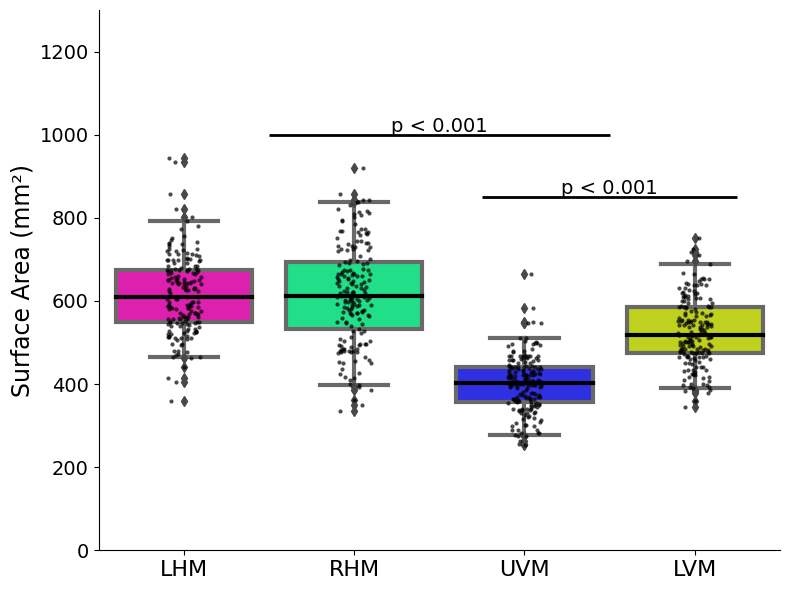

T-test between upper and lower areas: 3.1971962089977412e-18
T-value: 9.721742944463223
Cohen's d between upper and lower areas: 0.7830055485095504
T-test between horizontal and vertical areas: 2.6030745866432492e-42
T-value: 18.074541898756895
Cohen's d between horizontal and vertical areas: 1.3005995357573001


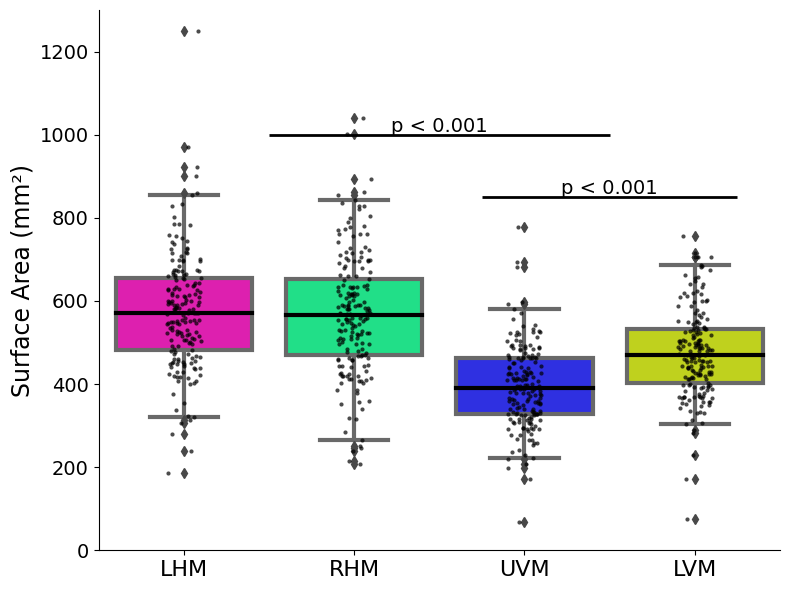

In [43]:
for method in ['deepRetinotopy', 'empirical']:
    generate_boxplot_surfarea_around_meridians(method)

## 3. Group differences in VMA and HVA

Up to this point, we have generated boxplots for surface areas around meridians using both deepRetinotopy and empirical retinotopic maps from the 7T HCP Retinotopy dataset to partition the visual field. In our manuscript, we also estimated these surface areas using all subjects from the HCP Young Adult dataset as well as the ABCD baseline cohort. To do so, we instead used a Python script that encapsulates all of the steps shown beforehand. The deepRetinotopy container includes all dependencies required to run the script, as shown below.

In [ ]:
!singularity exec  /BULK/LABDATA/containers/deepretinotopy_1.0.18_20250909.simg python ../visual-field-sampling/vf_analysis_script.py --freesurfer_dir path/to/freesurfer/ --template_dir /path/to/rois/ --hcp_dir path/to/hcptemplates --output_file /path/to/output-dir/output.csv --n_jobs 8

For illustration purpose, here we load the derivative data from a random sample of individuals from the ABCD dataset to compare with the HCP Young Adult dataset.

In [44]:
results_abcd = pd.read_csv('/home/ribeiro/Projects/deepRetinotopy_validation/scripts/visual-field-sampling/ABCD_vf_ageY_sex_1k.csv')
results_abcd['group'] = ['children'] * len(results_abcd)

results_hcp = pd.read_csv('/home/ribeiro/Projects/deepRetinotopy_validation/scripts/visual-field-sampling/test-hcp_1200_45.csv')
results_hcp['group'] = ['adults'] * len(results_hcp)

results_group = pd.concat([results_abcd, results_hcp], ignore_index=True)

T-test for deepRetinotopy VMA: Ttest_indResult(statistic=4.16767440540625, pvalue=3.201438612873181e-05)
T-test for deepRetinotopy VMA - p-value 3.201438612873181e-05, tstat 4.16767440540625
Cohen's d for deepRetinotopy VMA: 0.18163954842504818
Degree of freedom for HVA t-test: 2110
T-test for deepRetinotopy HVA - p-value 0.26107808789900594, tstat 1.1241480693217474
Cohen's d for deepRetinotopy HVA: 0.048993689960429694
Degree of freedom for HVA t-test: 2110


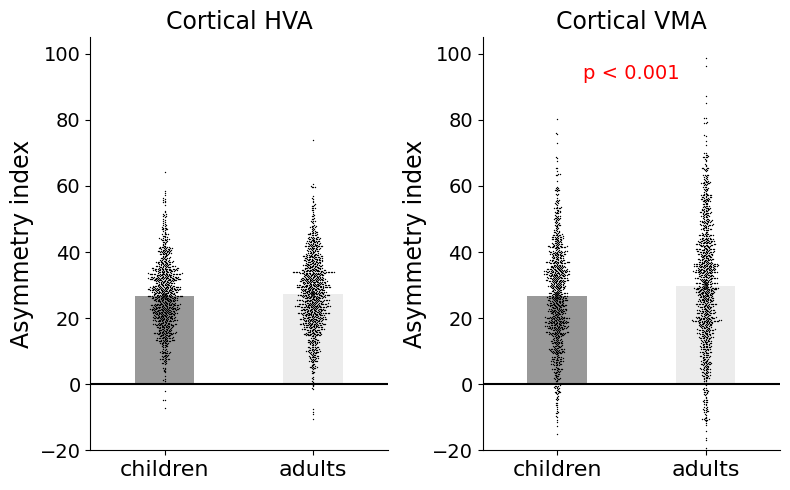

In [55]:
def generate_boxplot_group_difference(method):
    results_method = results_group[results_group['method'] == method].copy()
    ttest = scipy.stats.ttest_ind(results_method['cortical_vma'][results_method['group']=='adults'], results_method['cortical_vma'][results_method['group']=='children'])
    print(f'T-test for {method} VMA: {ttest}')
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))

    # Plot 1: Cortical VMA (top-left)
    plt.sca(axes[1])
    plt.hlines(0, -.5, 1.5, color='black')
    if method == 'empirical':
        plt.ylim(-30, 150)
    else:
        plt.ylim(-20, 105)
    
    sns.barplot(data=results_method, y='cortical_vma', x="group", errorbar='se', ax=axes[1], palette=['#999999ff', '#ecececff'], linewidth= 3, width=0.4,)
    sns.swarmplot(data=results_method, y='cortical_vma', x="group", ax=axes[1], color='black', size = 1)
    plt.ylabel('Asymmetry index', fontsize=17)
    plt.xlabel('')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)
    ttest_vma = scipy.stats.ttest_ind(results_method['cortical_vma'][results_method['group']=='adults'], results_method['cortical_vma'][results_method['group']=='children'])
    cohend_vma = cohend(results_method['cortical_vma'][results_method['group']=='adults'], results_method['cortical_vma'][results_method['group']=='children'])
    print(f'T-test for {method} VMA - p-value {ttest_vma.pvalue}, tstat {ttest_vma.statistic}')
    print(f"Cohen's d for {method} VMA: {cohend_vma}")
    print(f'Degree of freedom for HVA t-test: {len(results_method["cortical_hva"][results_method["group"]=="adults"]) + len(results_method["cortical_hva"][results_method["group"]=="children"]) - 2}')

    axes[1].set_title(f'Cortical VMA', fontsize=17)
    if ttest_vma.pvalue < 0.05:
        if ttest_vma.pvalue < 0.001:
            pvalue = '< 0.001'
            plt.text(0.5, 0.9, f'p {pvalue}', transform=axes[1].transAxes, ha='center', fontsize=14, color='red')

    # Plot 2: Cortical HVA (top-left)
    plt.sca(axes[0])
    plt.hlines(0, -.5, 1.5, color='black')
    if method == 'empirical':
        plt.ylim(-30, 150)
    else:
        plt.ylim(-20, 105)
    sns.barplot(data=results_method, y='cortical_hva', x="group", errorbar='se', ax=axes[0], palette=['#999999ff', '#ecececff'], linewidth= 3, width=0.4)
    sns.swarmplot(data=results_method, y='cortical_hva', x="group", ax=axes[0], color='black', size = 1)
    plt.ylabel('Asymmetry index', fontsize=17)
    plt.xlabel('')
    axes[0].set_title(f'Cortical HVA', fontsize=17)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=14)
    ttest_hva = scipy.stats.ttest_ind(results_method['cortical_hva'][results_method['group']=='adults'], results_method['cortical_hva'][results_method['group']=='children'])
    cohend_hva = cohend(results_method['cortical_hva'][results_method['group']=='adults'], results_method['cortical_hva'][results_method['group']=='children'])
    print(f'T-test for {method} HVA - p-value {ttest_hva.pvalue}, tstat {ttest_hva.statistic}')
    print(f"Cohen's d for {method} HVA: {cohend_hva}")
    print(f'Degree of freedom for HVA t-test: {len(results_method["cortical_hva"][results_method["group"]=="adults"]) + len(results_method["cortical_hva"][results_method["group"]=="children"]) - 2}')
    if ttest_hva.pvalue < 0.05:
        if ttest_hva.pvalue < 0.001:
            pvalue = '< 0.001'
            plt.text(0.5, 0.9, f'p {pvalue}', transform=axes[0].transAxes, ha='center', fontsize=14, color='red')


    output_dir = '../output/surface_area_exp'
    if os.path.exists(output_dir) is False:
        os.makedirs(output_dir)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f'{output_dir}/barplot_group_difference_{method}_wedge45.pdf', dpi=300, bbox_inches='tight')
    

    plt.show()

for method in ['deepRetinotopy']:
    generate_boxplot_group_difference(method)
    

## 4. Wedge-ROI visualization

Finally, for verification purpose, we can also visualize the wedge-ROIs as demonstrated below. Note that the upper and lower vertical meridian masks include nodes from V1 and V2. In our analyses, we divide those areas by factor of 2 as proxy for the surface area in V1 only. Previous work has shown that the surface area of V1 and V2 are [similar](https://www.nature.com/articles/s41467-023-37280-8).

In [49]:
def visualize_wedge_connected(subject, hemisphere, retinotopic_mapping, wedge_size = 45,
                              meridian='horizontal'):
    """
    Modified version of your function that keeps only connected components.
    """
    freesurfer_directory = '/home/ribeiro/Projects/deepRetinotopy_validation/HCP/freesurfer'
    surface = nib.load(f'{freesurfer_directory}/{subject}/surf/{hemisphere}.midthickness.surf.gii')
    
    upper_vm_mask, lower_vm_mask, horizontal_l_mask, horizontal_u_mask, polar_angle, _ = generate_masks(freesurfer_directory, subject, 
                                                                                        hemisphere, retinotopic_mapping, wedge_size=wedge_size)

    polar_angle_viz = polar_angle.copy()
    if (meridian == 'vertical'):
        mask = upper_vm_mask + lower_vm_mask
    elif (meridian == 'horizontal'):
        mask = horizontal_l_mask + horizontal_u_mask
    elif (meridian == 'both'):
        mask = upper_vm_mask + lower_vm_mask + horizontal_l_mask + horizontal_u_mask
    polar_angle_viz[mask !=1] = 0

    view = plotting.view_surf(
        surf_mesh=f'{freesurfer_directory}/{subject}/surf/{hemisphere}.sphere.reg.surf.gii',
        surf_map=np.reshape(polar_angle_viz[:], (-1)), bg_map=f'{freesurfer_directory}/{subject}/surf/{hemisphere}.graymid.H.gii',
        cmap='gist_rainbow', black_bg=False, symmetric_cmap=False,
        threshold=1, vmax=360 + 1)
    
    return view, upper_vm_mask, lower_vm_mask

In [52]:
subject_id=['100610']
prediction = Dropdown(options = ['empirical',
                                 'deepRetinotopy'])
hemisphere = Dropdown(options = ['lh', 'rh'])
meridian = Dropdown(options = ['horizontal', 'vertical', 'both'])

@interact(subject=subject_id, 
          hemisphere = hemisphere, prediction = prediction, meridian = meridian)
def plot1(subject, hemisphere, prediction, meridian):
    view, _, _ = visualize_wedge_connected(subject, hemisphere, 
                                           retinotopic_mapping=prediction, wedge_size = 25, meridian=meridian)
    return view

interactive(children=(Dropdown(description='subject', options=('100610',), value='100610'), Dropdown(descripti…